In [1]:
%matplotlib inline

#
# import utilitaires
#
import matplotlib.pyplot as plt
import numpy as np
import os
import pickle
import random
import seaborn as sns
import warnings

import helpers as hlp
import helpers.features as feat
import helpers.dataset.PlantVillage as pv
import helpers.split as split
import helpers.visual_words as vw

from sklearn.cluster import MiniBatchKMeans, DBSCAN
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, \
    f1_score, \
    confusion_matrix, \
    ConfusionMatrixDisplay, \
    calinski_harabasz_score, \
    davies_bouldin_score

from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, MinMaxScaler

from tqdm.notebook import tqdm

# enlever FutureWarning de sklearn 
warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
#
# parametres
#
configs = hlp.get_configs("config_overrides.json")


#
# train/test sets
# 
train, test = split.load(configs.split)
print("Train size", len(train))
print("Test size", len(test))


#
# dataset PlantVillage
#
pv_dataset = pv.load(configs.plant_village)
pv_dataframe = pv_dataset.dataframe

print("Dataset", pv_dataframe.shape)

Train size 3711
Test size 928
Dataset (60343, 4)


In [3]:
#
# features sift
#

configs.sift.force_generate = True
configs.sift.read_only = False

if "sift_features" in locals():
    del sift_features

with hlp.Profile() as sift_loading:
    #
    # obtenir les sift features pour chaque image du dataset
    #
    sift_iter = feat.DatasetIter(pv_dataset, 
                                 pv_dataframe.loc[train + test, "image_path"].items(),
                                 len(train + test))
    sift_features = feat.load(configs.sift, sift_iter)

print(f"SIFT loading:", sift_loading.round_duration(), "s")
print("SIFT keypoints", sift_features.key_points.shape)
print("SIFT features", sift_features.features.shape)

if configs.sift.force_generate or sift_features.train_features is None:
    feat.update_train_test(sift_features, train, test)

print("SIFT train features", sift_features.train_features.shape)
print("SIFT test features", sift_features.test_features.shape)

SIFT loading: 0.04 s
SIFT keypoints (1460929, 7)
SIFT features (1460929, 128)
SIFT train features (1169216, 128)
SIFT test features (291713, 128)


In [4]:
#
# reduction des features (voir notebook precedant pour savoir combien de component on garde sur SIFT)
#

pca_pipe = Pipeline([
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=configs.sift_bovw.pca_n_components, svd_solver="full", random_state=42))
     ])
sift_train_features_pca = pca_pipe.fit_transform(sift_features.train_features);

La litérature est relativement large sur le sujet des clusters. En effet, les techniques de regorupement par densité, par hiéarchie et distance sont toutes explorées. Cependant, nos expérimentations nous ont montrées que seul **MiniBatchKMeans** converge. En effet DBSCAN, SpectralClustering et autres ne terminent pas dans un temps raisonable ou crash tout simplement.

Il est difficile d'évaluer visuellement la qualité de notre clustering etant donné la dimentionalité de nos données. PCA et TSNE ne nous montrent pas un regroupement clair. Nous avons donc opté pour une approche plus simple. A savoir des clusters compactes quitte à avoir beaucoup de chevauchement. Nos métriques sont donc l'inertie (graphe en coude) et **skelarn.metrics.davies_bouldin_score** (recherche valeur minimale). 

* Mettre note pour epliquer **davies_bouldin_score**.
* Metrics pour trouver le nombres de K dans clustering
* https://scikit-learn.org/stable/modules/clustering.html#clustering-evaluation
* https://towardsdatascience.com/cheat-sheet-to-implementing-7-methods-for-selecting-optimal-number-of-clusters-in-python-898241e1d6ad

  0%|          | 0/45 [00:00<?, ?it/s]

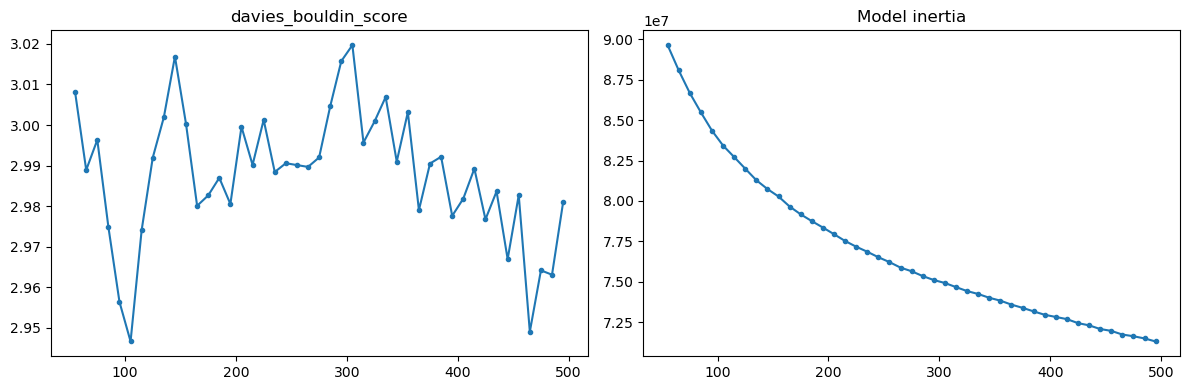

In [5]:
cluster_range = range(55, 501, 10)
cluster_scores = [[],[]]
for n_clusters in tqdm(cluster_range):
    cluster_model = MiniBatchKMeans(n_clusters=n_clusters,
                                    batch_size=256 * 12,
                                    random_state=42,
                                    n_init="auto")
    cluster_labels = cluster_model.fit_predict(sift_train_features_pca)

    # mesure la similarite entre les clusters; lower is better
    david_boutin = davies_bouldin_score(sift_train_features_pca, cluster_labels)

    # pour trouver un coude
    inertia = cluster_model.inertia_

    # prendre en note les mesures
    cluster_scores[0].append(david_boutin)
    cluster_scores[1].append(inertia)

    

    
# afficher les mesures
plt.figure(figsize=(12, 4))

plt.subplot(121)
plt.title("davies_bouldin_score")
plt.plot(cluster_range, cluster_scores[0], marker=".")

plt.subplot(122)
plt.title("Model inertia")
plt.plot(cluster_range, cluster_scores[1], marker=".")

plt.tight_layout()
plt.show()

D'après le graphe ci-haut, un bon nombre de clusters serait dans l'interval 100 à 200: minimum marqué par davies_bouldin_score et l'inflexion dans le diagrame de l'inertie semble devenir plutôt linéaire. Notre choix s'arrête donc sur 175. Cette information sera intégrée via nos fichiers de configuration.

In [4]:
#
# bovw sift
#

configs.sift_bovw.force_generate = True

if "sift_bovw" in locals():
    del sift_bovw

# soyez patient, ce n'est pas interactif
with hlp.Profile() as sift_bovw_profile:
    sift_bovw = vw.load_bovw(configs.sift_bovw, sift_features.train_features)

print("SIFT BoVW loading:", sift_bovw_profile.round_duration(), "s")
print("SIFT BoVW clusters:", sift_bovw.cluster_centers.shape)

SIFT BoVW loading: 0.01 s
SIFT BoVW clusters: (175, 80)


In [5]:
#
# dataset vw sift
#

configs.sift_dataset_vw.force_generate = True

if "sift_pv_vw" in locals():
    del sift_pv_vw

with hlp.Profile() as sift_pv_vw_loading:
    sift_pv_vw = vw.load_dataset_vw(configs.sift_dataset_vw,
                                   sift_features,
                                   configs.sift_bovw,
                                   sift_bovw,
                                   train,
                                   test)
    
print(f"SIFT PlantVillage Visual Word loading:", sift_pv_vw_loading.round_duration(), "s")
print("SIFT PlantVillage Visual Words", sift_pv_vw.vw_freqs.shape)

SIFT PlantVillage Visual Word loading: 0.04 s
SIFT PlantVillage Visual Words (4639, 175)


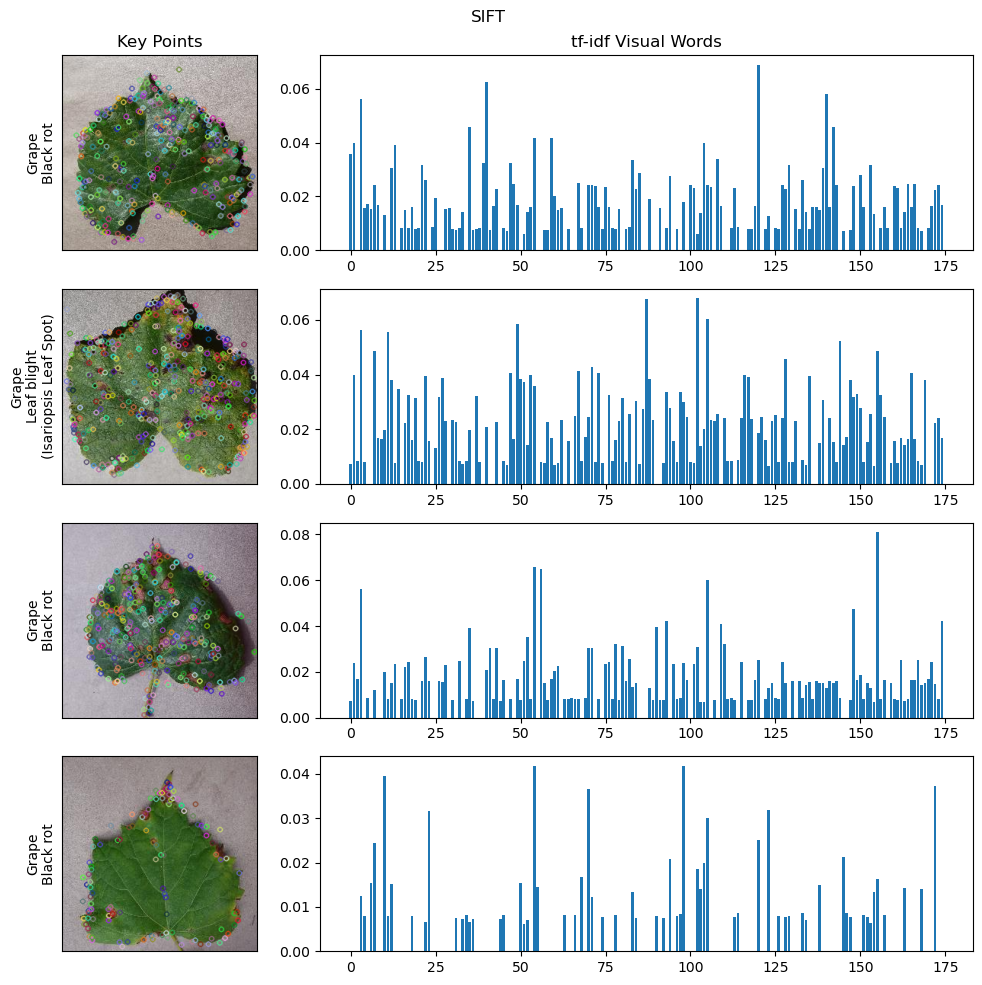

In [14]:
#
# visualiser quelques visual words sift
#

SAMPLES_GRID = (4, 2)
SAMPLES_COUNT = SAMPLES_GRID[0]
FIGSIZE = (10, SAMPLES_GRID[0] * 2.5)

def affiche_vw(image_indices, visual_words, idf, features, pv_vw):
    x_range = range(visual_words.n_clusters)
    figure, axes = plt.subplots(SAMPLES_GRID[0],
                                SAMPLES_GRID[1],
                                figsize=FIGSIZE,
                                width_ratios=[1, 3])

    for i, image_index in enumerate(image_indices):
        key_points = features.index_to_key_points[str(image_index)][...]
        visual_words_freq = pv_vw.index_to_vw_freqs[str(image_index)][...].flatten()
        tf_idf = np.multiply(idf, visual_words_freq)

        image = pv_dataset.get_image(image_index)
        image_key_points = visual_words.draw_key_points(image, key_points)

        species, disease = pv_dataframe.loc[image_index, ["species", "disease"]]
        disease = pv.attribute_prettify(species, disease)
        title = "\n".join([species, disease])

        plt.sca(axes[i, 0])
        plt.gca().set_ylabel(title)
        plt.gca().set_xticks([])
        plt.gca().set_yticks([])
        plt.imshow(image_key_points)

        plt.sca(axes[i, 1])
        plt.bar(x_range, tf_idf)

    axes[0, 0].set_title("Key Points")
    axes[0, 1].set_title("tf-idf Visual Words")
    

# selectionner quelques images aleatoirement
random.seed(55)
image_indices = random.choices(train, k=SAMPLES_COUNT)
image_indices.sort()

affiche_vw(image_indices,
           vw.VisualWords(configs.sift, sift_bovw),
           np.ravel(sift_bovw.idf),
           sift_features, 
           sift_pv_vw)

plt.suptitle("SIFT")
plt.tight_layout()
plt.show() 

In [6]:
#
# mettre le data dans une forme acceptable pour sklearn
#
train_y = pv_dataframe.loc[train, "label"]
test_y = pv_dataframe.loc[test, "label"]

# sift_pv_vw* garantissent l'ordre donne par train/test lors de l'etape precedante 
# alors faire gaffe a ne pas le changer
sift_train_x = np.multiply(sift_pv_vw.train_vw_freqs[...], sift_bovw.idf)
sift_test_x = np.multiply(sift_pv_vw.test_vw_freqs[...], sift_bovw.idf)

assert sift_train_x.shape[0] == train_y.shape[0]
assert sift_test_x.shape[0] == test_y.shape[0]

print("SIFT PlantVillage train Visual Words", sift_train_x.shape)
print("SIFT PlantVillage test Visual Words", sift_test_x.shape)

SIFT PlantVillage train Visual Words (3711, 175)
SIFT PlantVillage test Visual Words (928, 175)


Validation de **sift_train_x** juste avant la classification. On veut s'assurer qu'il y ait très peu de corrélation entre les featues.

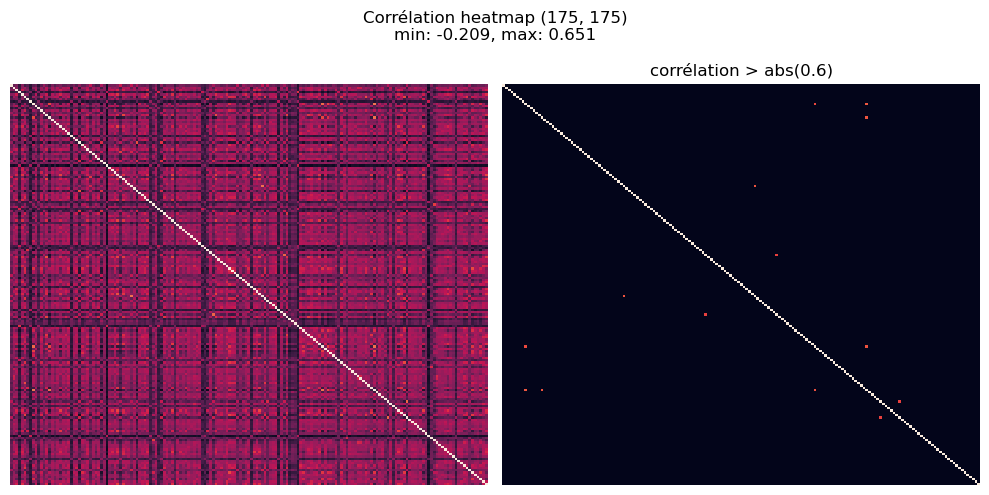

In [11]:
# transpose parce que numpy veux les variables dans les rangees
corr = np.corrcoef( sift_train_x.T )

# enlever 1 et -1
corr_no_one = np.where(np.isclose(corr, 1), 0, corr)
corr_max = np.max(corr_no_one)
corr_min = np.min(corr_no_one)

CORR_THRESHOLD = 0.6
corr_thresholded = np.where(abs(corr) > CORR_THRESHOLD, corr, 0)


plt.figure(figsize=(10, 5))

plt.subplot(121)
sns.heatmap(corr, cbar=False)
plt.xticks([])
plt.yticks([])

plt.subplot(122)
plt.title(f"corrélation > abs({CORR_THRESHOLD})")
sns.heatmap(corr_thresholded, cbar=False)
plt.xticks([])
plt.yticks([])

plt.suptitle(f"Corrélation heatmap {corr.shape}\nmin: {round(corr_min, 3)}, max: {round(corr_max, 3)}")
plt.tight_layout()
plt.show()

Search time: 2.14 s
Best params {'knn__n_neighbors': 4, 'knn__weights': 'distance'}
Train score: 0.7556

SIFT KNN n_neighbors: 4
SIFT KNN test score: 0.7511
SIFT KNN f1 score: 0.7511

Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


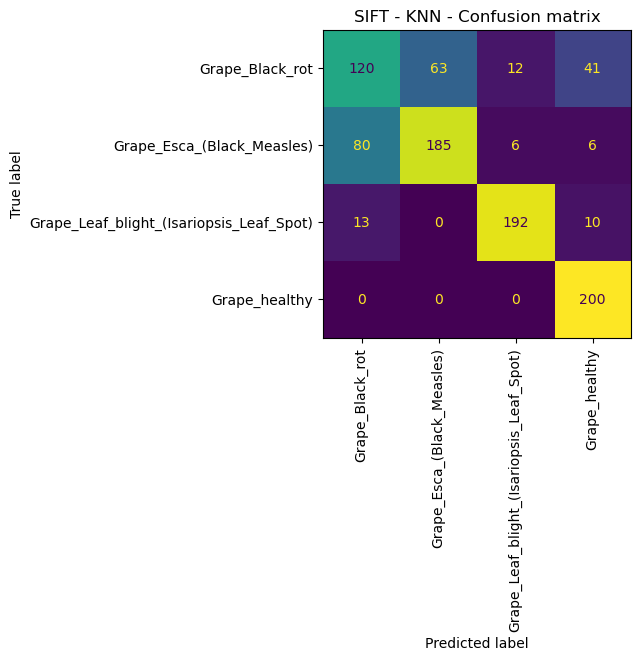

In [7]:
def load_knn(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5
        
        pipe = Pipeline([("scaler", StandardScaler()),
                         ("knn", KNeighborsClassifier(n_jobs=-1))])

        pipe_parameters = {"knn__n_neighbors": range(1, 5),
                           "knn__weights": ["uniform", "distance"]}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_knn(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "KNN n_neighbors:", pipe.named_steps["knn"].n_neighbors)
    print(method_name, "KNN test score:", accuracy_score(test_y, test_y_hat).round(4))
    print(method_name, "KNN f1 score:", f1_score(test_y, test_y_hat, average="micro").round(4))
    print()
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - KNN - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()

#
# SIFT KNN
#
sift_knn_pipe = load_knn("models/sift_knn.pkl", sift_train_x, train_y)
analysis_knn("SIFT", sift_knn_pipe, sift_test_x, test_y)

Search time: 140.38 s
Best params {'forest_gump__n_estimators': 176}
Train score: 0.8281

SIFT Random Forest n_estimators: 176
SIFT Random Forest test score: 0.8287
SIFT Random f1 score: 0.8287

Effectifs test set:
Grape_Esca_(Black_Measles)                  277
Grape_Black_rot                             236
Grape_Leaf_blight_(Isariopsis_Leaf_Spot)    215
Grape_healthy                               200
Name: label, dtype: int64


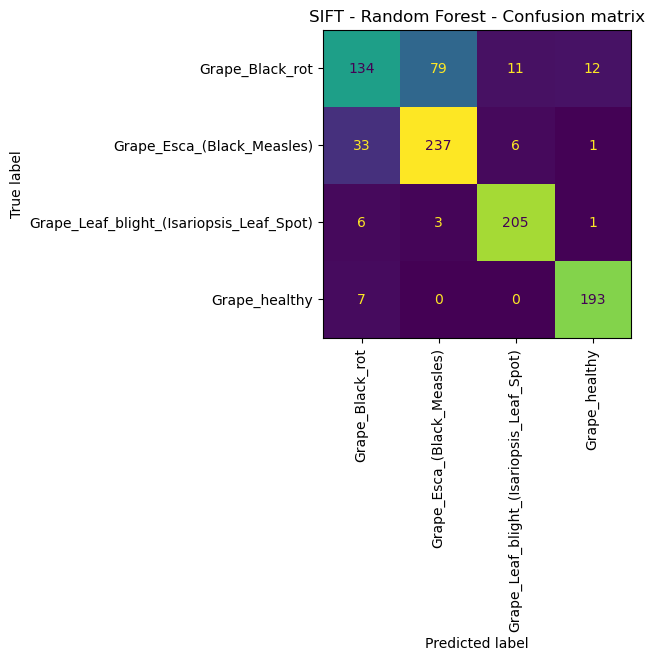

In [8]:
def load_rf(model_filename, train_x, train_y):
    """
    Utilitaire pour entrainer un model et le serialiser
    """
    if False and os.path.exists(model_filename):
        # charger le modele pre-entrainer
        with open(model_filename, "rb") as file:
            pipe = pickle.load(file)
    else:
        # trouver meilleurs parametres pour n_neighbors
        CROSS_VALIDATION_FOLDS = 5

        pipe = Pipeline([("scaler", StandardScaler()),
                         ("forest_gump", RandomForestClassifier(random_state=42, n_jobs=-1))])

        pipe_parameters = {"forest_gump__n_estimators": range(50, 200)}

        grid_search = GridSearchCV(pipe, 
                                  pipe_parameters, 
                                  scoring="accuracy",
                                  refit=True,
                                  cv=CROSS_VALIDATION_FOLDS,
                                  n_jobs=-1)

        with hlp.Profile() as grid_search_time:
            grid_search.fit(train_x, train_y)

        # sauvegarde du meilleur modele knn
        pipe = grid_search.best_estimator_
        head, _ = os.path.split(model_filename)
        os.makedirs(head, exist_ok=True)
        with open(model_filename, "wb") as file:
            pickle.dump(pipe, file)

        # afficher quelques stats
        print("Search time:", grid_search_time.round_duration(), "s")
        print("Best params", grid_search.best_params_)
        print("Train score:", grid_search.best_score_.round(4))
        print()
            
    return pipe

def analysis_rf(method_name, pipe, test_x, test_y):
    test_y_hat = pipe.predict(test_x)

    print(method_name, "Random Forest n_estimators:", pipe.named_steps["forest_gump"].n_estimators)
    print(method_name, "Random Forest test score:", accuracy_score(test_y, test_y_hat).round(4))
    print(method_name, "Random f1 score:", f1_score(test_y, test_y_hat, average="micro").round(4))
    print()
    print("Effectifs test set:")
    print( test_y.value_counts() )

    # confusion matrix
    plt.figure(figsize=(5, 4))

    cm = confusion_matrix(test_y, test_y_hat)
    cmd = ConfusionMatrixDisplay(cm, display_labels=pipe.classes_)
    cmd.plot(ax=plt.gca())
    cmd.im_.colorbar.remove()

    plt.title(f"{method_name} - Random Forest - Confusion matrix")
    plt.xticks(rotation=90)
    plt.show()
    

#
# SIFT Random Forest
#
sift_rf_pipe = load_rf("models/sift_random_forest.pkl", sift_train_x, train_y)
analysis_rf("SIFT", sift_rf_pipe, sift_test_x, test_y)